In [45]:
import numpy as np
import os
import pandas as pd
import torch
import albumentations as A
import albumentations.pytorch
import cv2
import sys
import random
import csv
import json
import matplotlib.pyplot as plt

sys.path.append('../')
from visualize import visualize
from utils import *

%matplotlib inline

In [46]:
df = pd.read_csv('../saved/df.csv')
df.shape

(25443, 14)

In [47]:
df.head()

,file_name,task,label,xmin,ymin,w,h,occluded,des,cell_type,bbox,area,ratio,ID
0,patch_images/2021.01.14/LBC424-20210111(1)/LBC...,[AS6] LBC424,C,1539,199,139,211,0,NaN,ASC-US,"[1539, 199, 139, 211]",171,0.811645,0
1,patch_images/2021.01.14/LBC424-20210111(1)/LBC...,[AS6] LBC424,AS,1337,102,256,136,0,NaN,ASC-US,"[1337, 102, 256, 136]",186,1.371989,1
2,patch_images/2021.01.14/LBC424-20210111(1)/LBC...,[AS6] LBC424,AS,220,619,166,169,0,NaN,ASC-US,"[220, 619, 166, 169]",167,0.991085,2
3,patch_images/2021.01.14/LBC424-20210111(1)/LBC...,[AS6] LBC424,AS,658,1747,191,166,0,NaN,ASC-US,"[658, 1747, 191, 166]",178,1.072661,3
4,patch_images/2021.01.14/LBC424-20210111(1)/LBC...,[AS6] LBC424,AS,1571,365,136,146,0,NaN,ASC-US,"[1571, 365, 136, 146]",140,0.965146,4


In [48]:
df.label.value_counts()

AS                           6562
Negative                     4468
LS                           3083
ASC-US                       2897
LSIL                         1689
ASC-US with HPV infection    1603
AH                            962
HS                            667
SC                            662
HSIL                          548
C                             527
LSIL with HPV infection       479
Candida                       402
N - Endocervical Cell         306
ASC-H                         263
HSIL with HPV infection       142
HN                            102
Benign atypia                  46
Carcinoma                      18
H                               9
판독불가                            4
ASCUS-SIL                       2
ASC-H with HPV infection        1
N - Endometrial cell            1
Name: label, dtype: int64

In [42]:
df.loc[1][ ['task','label']]

task     [AS6] LBC424
label              AS
Name: 1, dtype: object

In [44]:
# df.iloc[0, ['task','label']]

In [4]:
df.label.value_counts()

AS                           6562
Negative                     4468
LS                           3083
ASC-US                       2897
LSIL                         1689
ASC-US with HPV infection    1603
AH                            962
HS                            667
HSIL                          548
C                             527
LSIL with HPV infection       479
Candida                       402
N - Endocervical Cell         306
ASC-H                         263
HSIL with HPV infection       142
HN                            102
Benign atypia                  46
Carcinoma                      18
H                               9
판독불가                            4
ASCUS-SIL                       2
N - Endometrial cell            1
ASC-H with HPV infection        1
SC                              1
Name: label, dtype: int64

<AxesSubplot:>

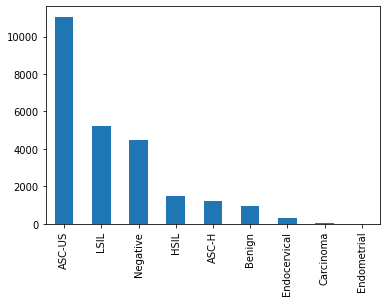

In [5]:
df.label = df.label.apply(lambda x : CLASS_MAPPER[x])
df.label.value_counts().plot(kind='bar')

In [6]:
df[(df['w'] > 400) & (df['h'] > 400) & (df['label']!='Candida')].shape

(564, 13)

[1514 1330 475 416]
Benign


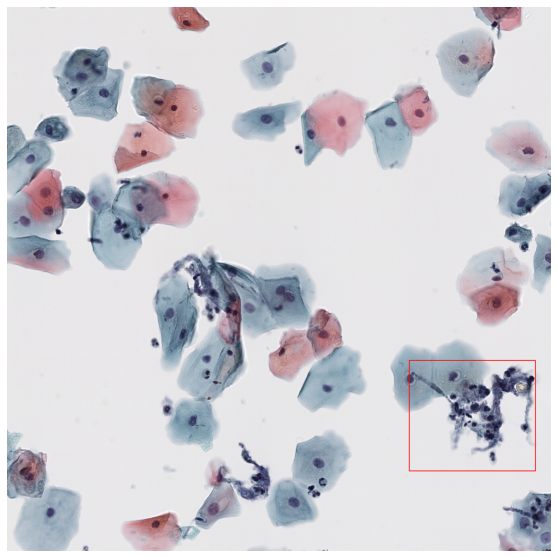

In [7]:
NUM = 15
f_name = df[(df['w'] > 400) & (df['h'] > 400) & (df['label']!='Candida')].file_name.iloc[NUM]
boxes = df[(df['w'] > 400) & (df['h'] > 400) & (df['label']!='Candida')].iloc[NUM][['xmin', 'ymin', 'w', 'h']].values
label = df[(df['w'] > 400) & (df['h'] > 400) & (df['label']!='Candida')].label.iloc[NUM]
print(boxes)
print(label)
abs_path = '/home/Dataset/scl/'
img = cv2.imread(abs_path+f_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
visualize(img, [boxes])

In [8]:
df.label.value_counts()

ASC-US          11064
LSIL             5251
Negative         4472
HSIL             1468
ASC-H            1226
Benign            975
Endocervical      306
Carcinoma          19
Endometrial         1
Name: label, dtype: int64

In [9]:
df[df['label'] == 'ASC-US'].w.describe()

count    11064.000000
mean       171.994758
std         71.243104
min          4.000000
25%        124.000000
50%        158.000000
75%        205.000000
max        726.000000
Name: w, dtype: float64

In [10]:
df[df['label'] == 'LSIL'].w.describe()

count    5251.000000
mean      207.053894
std        96.239528
min         2.000000
25%       146.000000
50%       189.000000
75%       241.000000
max      1554.000000
Name: w, dtype: float64

In [11]:
# df[df['label'] == 'LSIL with HPV infection'].w.describe()


In [12]:
# df[df['label'] == 'ASC-US with HPV infection'].w.describe()

In [13]:
df[df['label'] == 'ASC-US'].w.describe()

count    11064.000000
mean       171.994758
std         71.243104
min          4.000000
25%        124.000000
50%        158.000000
75%        205.000000
max        726.000000
Name: w, dtype: float64

In [14]:
# path_ascus = df[df['label'] == 'ASC-US'].path.values
def set_label_id(x) :
    if 'ASC-US' in x or 'AS' in x :
        return 1.
    elif 'LSIL' in x or 'LS' in x :
        return 2.
    elif 'HSIL' in x or 'HS' in x :
        return 3. 
    else :
        return 4
df['label_id'] = df.label.apply( lambda x : set_label_id(x))    

In [15]:

df_data = df.groupby('file_name')
def get_data(img_id):
    if img_id not in df_data.groups:
        return dict(image_id=img_id, source='', boxes=list())
    
    data  = df_data.get_group(img_id)
#     boxes = data['bbox'].values
    boxes = data[['xmin', 'ymin', 'w', 'h', 'label_id']].values
#     labels = data['label'].values
    return dict(image_id = img_id, boxes = boxes)
#     return dict(image_id = img_id, boxes = boxes, labels=labels)

image_list = [get_data(img_id) for img_id in df.file_name.unique()]
# df.head()
image_list[0]

{'image_id': 'patch_images/2021.01.14/LBC424-20210111(1)/LBC424-20210111(1)_425.png',
 'boxes': array([[1539.,  199.,  139.,  211.,    4.]])}

In [16]:
ascus_list = [get_data(img_id) for img_id in df[df['label_id'] == 1.].file_name.unique()]

In [17]:
ascus_list[0]

{'image_id': 'patch_images/2021.01.14/LBC424-20210111(1)/LBC424-20210111(1)_330.png',
 'boxes': array([[1.337e+03, 1.020e+02, 2.560e+02, 1.360e+02, 1.000e+00]])}

In [18]:
abs_path = '/home/Dataset/scl/'
print(abs_path+ascus_list[0]['image_id'])

/home/Dataset/scl/patch_images/2021.01.14/LBC424-20210111(1)/LBC424-20210111(1)_330.png


In [19]:
ascus_list[0]['boxes']

array([[1.337e+03, 1.020e+02, 2.560e+02, 1.360e+02, 1.000e+00]])

<class 'numpy.ndarray'>


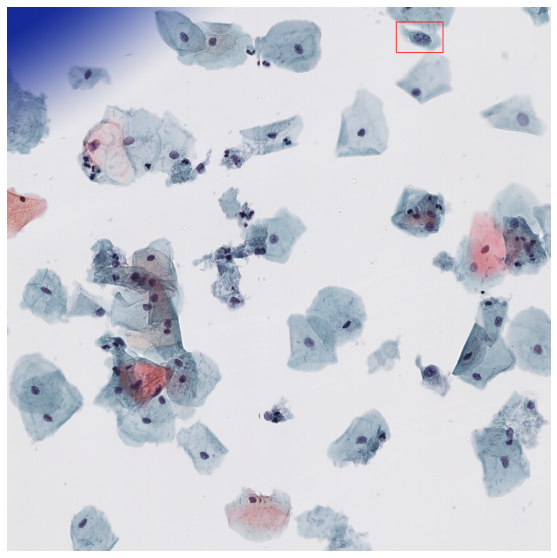

In [20]:
NUMBER = 70
img = cv2.imread(abs_path+ascus_list[NUMBER]['image_id'])
print(type(img))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img.shape
visualize(img, ascus_list[NUMBER]['boxes'])

In [21]:
ascus_hpv_list = [get_data(img_id) for img_id in df[df['label'] == 'ASC-US with HPV infection'].file_name.unique()]
# ascus_hpv_list[0]
# NUMBER = 1
# img = cv2.imread(abs_path+ascus_hpv_list[NUMBER]['image_id'])
# print(type(img))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img.shape
# visualize(img, ascus_hpv_list[NUMBER]['boxes'])

In [22]:
lsil_list = [get_data(img_id) for img_id in df[df['label'] == 'LSIL'].file_name.unique()]
lsil_list[0]

{'image_id': 'patch_images/2021.01.06/LBC37-20210102(1)/LBC37-20210102(1)_1519.png',
 'boxes': array([[472., 768., 237., 271.,   2.]])}

<class 'numpy.ndarray'>
[[788.  39. 128. 209.   2.]]
[[788.  39. 128. 209.   2.]]


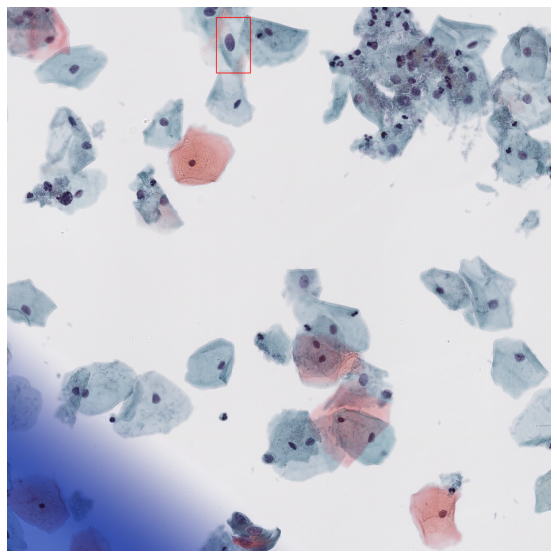

In [23]:
NUMBER = 41
img = cv2.imread(abs_path+lsil_list[NUMBER]['image_id'])
print(type(img))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(lsil_list[NUMBER]['boxes'])
visualize(img, lsil_list[NUMBER]['boxes'])
print(lsil_list[NUMBER]['boxes'])

In [24]:
df.label.value_counts()

ASC-US          11064
LSIL             5251
Negative         4472
HSIL             1468
ASC-H            1226
Benign            975
Endocervical      306
Carcinoma          19
Endometrial         1
Name: label, dtype: int64

count    11064.000000
mean       171.994758
std         71.243104
min          4.000000
25%        124.000000
50%        158.000000
75%        205.000000
max        726.000000
Name: w, dtype: float64


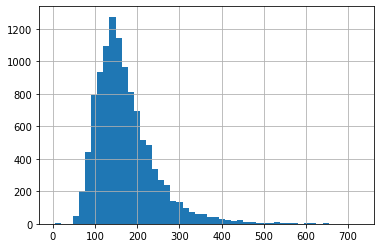

In [25]:
df[df['label'] == 'ASC-US'].w.hist(bins=50)
print(df[df['label'] == 'ASC-US'].w.describe())

count    5251.000000
mean      207.053894
std        96.239528
min         2.000000
25%       146.000000
50%       189.000000
75%       241.000000
max      1554.000000
Name: w, dtype: float64


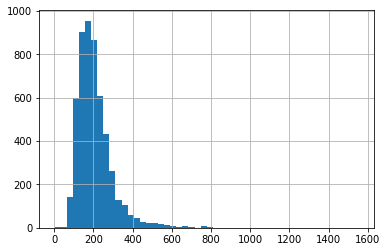

In [26]:
df[df['label'] == 'LSIL'].w.hist(bins=50)
print(df[df['label'] == 'LSIL'].w.describe())